# Linear truss event-to-event collapse analysis.

In [1]:
import ema as em
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
mdl = em.Model(2,2)
n = mdl.dnodes
e = mdl.delems
mdl.material('default', 10000)

mdl.node('1', 0.0, 0.0)
mdl.node('2', 8.0, 0.0)
mdl.node('3', 0.0, 6.0)
mdl.node('4', 8.0, 6.0)
mdl.node('5', 0.0,12.0)

mdl.truss('a', n['2'], n['4'])
mdl.truss('b', n['1'], n['4'])
mdl.truss('c', n['3'], n['4'])
mdl.truss('d', n['5'], n['4'])

for elem in mdl.elems:
    elem.Qp['+']['1'] = elem.Qp['-']['1'] = 15

mdl.pin(n['1'])
mdl.pin(n['2'])
mdl.pin(n['3'])
mdl.pin(n['5'])

mdl.numDOF()

[[3, 4], [5, 6], [7, 8], [1, 2], [9, 10]]

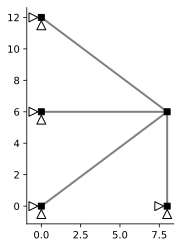

In [3]:
fig1, ax1 = plt.subplots()
em.plot_structure(mdl, ax1)

In [4]:
A = em.A_matrix(mdl)

In [5]:
Fs = em.Fs_matrix(mdl)
Fs

,$a_1$,$b_1$,$c_1$,$d_1$
$a_1$,0.0006,0.000,0.0000,0.000
$b_1$,0.0000,0.001,0.0000,0.000
$c_1$,0.0000,0.000,0.0008,0.000
$d_1$,0.0000,0.000,0.0000,0.001


In [6]:
Pref = em.P_vector(mdl).f
Pref.set_item('1', 20)
Pref.set_item('2', 10)
Pref

,$P_{{}}$
$1$,20.0
$2$,10.0


In [7]:
Model = mdl
def LinearE2E(Model, Pref):
    # form kinematic matrix A for all dofs of structural model and extract Af matrix from free dofs
    Af = em.A_matrix(Model).f

    nf = Model.nf

    # set up element diagonal flexibility matrix, Fs
    Fs  = em.Fs_matrix(Model)

    # extract plastic capacity data from to set up Qpl array
    Qpl = em.Qpl_vector(Model)

    # initializations
    k        = 0              # load step counter
    lamdah   = np.zeros(1)    # load factor
    nq       = sum(Model.nq)  # number of basic forces in model
    Qh  = np.zeros((nq,1))    # basic element forces
    Ufh = np.zeros((nf,1))    # displacements at free dofs
    Vph = np.zeros((nq,1))    # plastic deformations

    # initialize indices of basic forces, plastic hinge locations and non-trivial equilibrium equations
    ind_e = Model.idx_c        # indices of continuous/elastic basic forces
    ind_n = np.arange(nf)      # indices of non-trivial equilibrium equations     
    Iph   = np.array([])       # indices of plastic hinge locations
    
    
    # Loop until the structure is unstable
    Af0 = Af[ind_e, :].del_zeros()
    while np.linalg.matrix_rank(Af0)==len(ind_n):
        # set up stiffness matrix and solve for free dof displacements
        
        KsAf = (Fs[ind_e,:][:,ind_e]).inv @ Af0
        Kf   = Af0.T @ KsAf
        Ufe  = np.zeros((nf,1))
        Ufe[ind_n,0]  = Kf.inv @ Pref[ind_n]

        # determine basic element forces Qe (elastic increment)
        Qe = np.zeros((nq,1))
        Qe[ind_e,:] = KsAf @ Ufe[ind_n]

        # distinguish positive and negative basic force values
        ineg = np.where(Qe[ind_e,:]<0)[0]
        ne   = len(ind_e)
#         ipos = np.array([int(idx) for idx in np.where(Qe[ind_e,:]>=0)[0]], dtype=int)
        ipos = np.where(Qe[ind_e,:]>=0.0)[0]

        ipe  = ind_e[ipos]
        ine  = ind_e[ineg]

        # set up residual plastic capacity Qplres for elastic locations
        Qplres = np.zeros((ne,1))
#         Qplres = np.sign(Qe[ind_e]+2e-52)*Qpl[ind_e]-Qh[ind_e,k]
        Qplres[ipos,0] =  Qpl[ipe, 0] - Qh[ipe, k]    
        Qplres[ineg,0] = -Qpl[ine, 1] - Qh[ine, k] 

        # form demand capacity ratio DC for elastic basic forces
        DC        = np.zeros((nq,1))
        DC[ind_e] = Qe[ind_e]/Qplres
        
        # determine location of maximum DC
        new_hinge = np.where(DC == np.amax(DC))[0]
        
        # determine load factor increment for next hinge formation (use one hinge only)
        Dlamda     = 1/DC[new_hinge[0]]
        
        # update load factor
        lamdah = np.append(lamdah, lamdah[k] + Dlamda)

        # update global dof displacements and basic element forces with elastic increment
        Ufh = np.append(Ufh, np.array([Ufh[:,k] + Ufe@Dlamda]).T, axis=1)
        Qh = np.append(Qh, np.array([Qh[:,k] + Qe@Dlamda]).T, axis=1)


        # update list of plastic hinge locations (several hinges can form simultaneously)
        Iph   = np.append(Iph, new_hinge.T)

        # locate trivial equilibrium equations and set displacement equal to previous step
        ind_t = np.setdiff1d(list(range(nf)), ind_n)
        Ufh[ind_t, k+1] = Ufh[ind_t,k]

        # determine plastic deformations by Vpl = Af*Uf - Fs*Q
        Vph = np.append(Vph, np.array([Af@Ufh[:,k+1] - Fs@Qh[:,k+1]]).T, axis=1)

        # update list of elastic basic forces by removing new plastic hinge locations
        ind_e = np.setdiff1d(ind_e, new_hinge.T)

        # remove any columns of Af with all zero entries (trivial equilibrium equations)
        
        Af0 = Af[ind_e, :]
        # increment step counter
        k += 1
        
    return lamdah, Qh, Ufh, Vph, Iph

In [8]:
lamdah, Qh, Ufh, Vph, Iph = LinearE2E(Model,Pref)
lamdah

array([0.        , 1.518     , 1.62348837, 1.77      ])

In [9]:
assert abs(lamdah[1] - 1.518) < 1e-6
assert abs(lamdah[2] - 1.62348837) < 1e-6
assert abs(lamdah[3] - 1.77) < 1e-6

In [10]:
# assert abs(lamdah[1] - 1.528) < 1e-6
# assert abs(lamdah[2] - 1.62448837) < 1e-6
# assert abs(lamdah[3] - 1.78) < 1e-6

In [11]:
em.K_matrix(mdl)

,$1$,$2$,$3$,$4$,$5$,$6$,$7$,$8$,$9$,$10$
$P_{1}$,2530.0,0.00000,-640.0,-480.0,0.0,0.00000,-1250.0,0.0,-640.0,480.0
$P_{2}$,0.0,2386.66667,-480.0,-360.0,0.0,-1666.66667,0.0,0.0,480.0,-360.0
$P_{3}$,-640.0,-480.00000,640.0,480.0,0.0,0.00000,0.0,0.0,0.0,0.0
$P_{4}$,-480.0,-360.00000,480.0,360.0,0.0,0.00000,0.0,0.0,0.0,0.0
$P_{5}$,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
$P_{6}$,0.0,-1666.66667,0.0,0.0,0.0,1666.66667,0.0,0.0,0.0,0.0
$P_{7}$,-1250.0,0.00000,0.0,0.0,0.0,0.00000,1250.0,0.0,0.0,0.0
$P_{8}$,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
$P_{9}$,-640.0,480.00000,0.0,0.0,0.0,0.00000,0.0,0.0,640.0,-480.0
$P_{10}$,480.0,-360.00000,0.0,0.0,0.0,0.00000,0.0,0.0,-480.0,360.0
